In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import  StandardScaler, OrdinalEncoder
import lightgbm as lgbm
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import (accuracy_score,
                             roc_auc_score, 
                             roc_curve,
                             precision_score, 
                             recall_score, 
                             f1_score, 
                             classification_report, 
                             confusion_matrix)
from lightgbm import LGBMClassifier

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [3]:
df_test = pd.read_parquet('E:/Phat/imbalance/df_test.parquet')
df_train  = pd.read_parquet('E:/Phat/imbalance/df_train.parquet')


In [4]:
target = 'fraud'

X = df_train.drop(columns=[target])
y = df_train[target]

[Text(0, 0.5, '4379498'), Text(0, 0.5, '56163')]

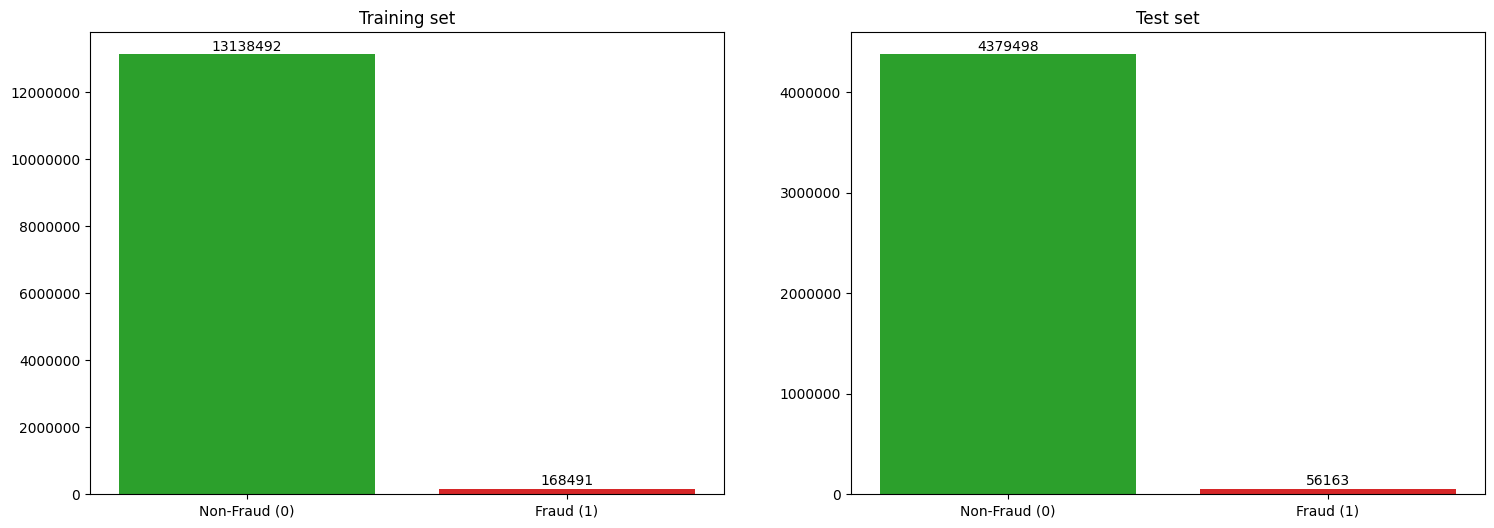

In [5]:
import matplotlib.pyplot as plt

# Tinh so luong  fraud va nonfraud trong 3 tap train, test va validation
non_fraud_train, fraud_train = df_train[target].value_counts()
non_fraud_test, fraud_test = df_test[target].value_counts()
# non_fraud_valid, fraud_valid = df_valid.value_counts()

# Ve bieu do bar chart the hien so luong fraud va non fraud
x = ['Non-Fraud (0)', 'Fraud (1)']
y1 = [non_fraud_train, fraud_train]
y2 = [non_fraud_test, fraud_test]
# y3 = [non_fraud_valid, fraud_valid]
bar_color = ['tab:green','tab:red']

fig, axs = plt.subplots(1,2, figsize=(18,6))

bar1 = axs[0].bar(x, y1, color=bar_color)
axs[0].set_title('Training set')
axs[0].ticklabel_format(style='plain', axis='y')
axs[0].bar_label(bar1, padding= 0.5, fmt = '{:.0f}')

bar2 = axs[1].bar(x, y2, color=bar_color)
axs[1].set_title('Test set')
axs[1].ticklabel_format(style='plain', axis='y')
axs[1].bar_label(bar2, padding= 0.5, fmt = '{:.0f}')

# bar3 = axs[2].bar(x, y3, color=bar_color)
# axs[2].set_title('Validation set')
# axs[2].ticklabel_format(style='plain', axis='y')
# axs[2].bar_label(bar3, padding= 0.5, fmt = '{:.0f}')



# XGB

In [6]:
from sklearn.base import BaseEstimator, TransformerMixin
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

# Tạo custom transformer để thực hiện oversampling và undersampling
class ResampleTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, oversampler, undersampler):
        self.oversampler = oversampler
        self.undersampler = undersampler

    def fit(self, X, y):
        # Không cần fit gì ở đây, chỉ cần trả về chính X, y
        return self

    def transform(self, X, y=None):
        # Áp dụng oversampling rồi đến undersampling nếu y không phải None
        if y is not None:
            X_res, y_res = self.oversampler.fit_resample(X, y)
            X_res, y_res = self.undersampler.fit_resample(X_res, y_res)
            return X_res, y_res
        return X  # Nếu y là None, chỉ trả về X


In [7]:
SEED = 42   
xgb_params = {
    # 'enable_categorical': True,
    'tree_method':        'hist',
    'random_state':       SEED,
    'learning_rate':      0.08501257473292347,
    'lambda':             8.879624125465703,
    'alpha':              0.6779926606782505,
    'max_depth':          6,
    'subsample':          0.6012681388711075,
    'colsample_bytree':   0.8437772277074493,
    'colsample_bylevel':  0.5476090898823716,
    'colsample_bynode':   0.9928601203635129,
    'scale_pos_weight':   3.29440313334688,
}

lgb_params = {
    'objective':        'binary',
    'verbosity':        -1,
    'n_iter':           200,
    'boosting_type':    'gbdt',
    'random_state':     SEED,
    'lambda_l1':        0.08758718919397321,
    'lambda_l2':        0.0039689175176025465,
    'learning_rate':    0.03231007103195577,
    'max_depth':        4,
    'num_leaves':       103,
    'colsample_bytree': 0.8329551585827726,
    'colsample_bynode': 0.4025961355653304,
    'bagging_fraction': 0.7738954452473223,
    'bagging_freq':     4,
    'min_data_in_leaf': 85,
    'scale_pos_weight': 2.7984184778875543,
    # 'device': 'gpu'
}

cb_params = {
    'loss_function':     'Logloss',
    'iterations':        250,
    'verbose':           False,
    'random_state':      SEED,
    'max_depth':         7,
    'learning_rate':     0.06936242010150652,
    'scale_pos_weight':  2.6149345838209532,
    'l2_leaf_reg':       6.216113851699493,
    'subsample':         0.6249261779711819,
    'min_data_in_leaf':  24,
    # 'cat_features':      cat_cols,
}

# Tạo pipeline với resampling
oversampler = RandomOverSampler(sampling_strategy=0.03, random_state=SEED)
undersampler = RandomUnderSampler(sampling_strategy=0.03, random_state=SEED)

# # Tạo pipeline với oversampling và undersampling
# augmentation = Pipeline([
#     ('oversample', oversampler),
#     ('undersample', undersampler)
# ])

# # Áp dụng resampling vào tập huấn luyện
# X_train_resampled, y_train_resampled = augmentation.fit_resample(X_train, y_train)

# # In ra số lượng nhãn 0 và 1 sau khi resampling
# print("After resampling:")
# print("Count of label 0:", np.sum(y_train_resampled == 0))
# print("Count of label 1:", np.sum(y_train_resampled == 1))

In [8]:
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
import xgboost as xgb
SEED = 42
X = df_train.drop(columns=[target])
y = df_train[target]
# Sử dụng StratifiedKFold để đảm bảo tỷ lệ lớp
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

# Tính toán scale_pos_weight để xử lý mất cân bằng dữ liệu
class_imbalance_ratio = sum(y == 0) / sum(y == 1)
scale_pos_weight = class_imbalance_ratio  # Tỷ lệ giữa lớp âm và lớp dương

# Khởi tạo mô hình CatBoost với các siêu tham số tốt nhất
model = xgb.XGBClassifier(**xgb_params)

# Khởi tạo các phương pháp resampling
oversampler = RandomOverSampler(sampling_strategy=0.03, random_state=SEED)
undersampler = RandomUnderSampler(sampling_strategy=0.03, random_state=SEED)

# Tạo pipeline hoàn chỉnh sử dụng custom transformer
full_pipeline = Pipeline([
    ('resample', ResampleTransformer(oversampler, undersampler)),
    ('model', model)
])
# Định nghĩa hàm custom metric
def custom_metric(estimator, X, y_true):
    y_hat = estimator.predict_proba(X)[:, 1]
    min_tpr = 0.80
    max_fpr = abs(1 - min_tpr)
    
    v_gt = abs(y_true - 1)
    v_pred = np.array([1.0 - x for x in y_hat])
    
    partial_auc_scaled = roc_auc_score(v_gt, v_pred, max_fpr=max_fpr)
    partial_auc = 0.5 * max_fpr**2 + (max_fpr - 0.5 * max_fpr**2) / (1.0 - 0.5) * (partial_auc_scaled - 0.5)
    
    return partial_auc

# Đánh giá mô hình bằng cross-validation với custom transformer
print("Performing cross-validation with Augmentation...")
cross_val_results = cross_validate(
    full_pipeline,
    X,
    y,
    cv=skf,
    scoring=custom_metric,
    verbose=1
)

# In ra kết quả cross-validation
print(f'Cross-validation pAUC scores: {cross_val_results["test_score"]}')
print(f'Mean pAUC: {cross_val_results["test_score"].mean():.4f}, Std: {cross_val_results["test_score"].std():.4f}')

# Huấn luyện mô hình cuối cùng trên toàn bộ dữ liệu
print("Training final model on the entire combined dataset...")
full_pipeline.fit(X, y)

Performing cross-validation with Augmentation...
Cross-validation pAUC scores: [0.19997153 0.19997135 0.19997099 0.19997025 0.19997387]
Mean pAUC: 0.2000, Std: 0.0000
Training final model on the entire combined dataset...


Pipeline(steps=[('resample',
                 ResampleTransformer(oversampler=RandomOverSampler(random_state=42,
                                                                   sampling_strategy=0.03),
                                     undersampler=RandomUnderSampler(random_state=42,
                                                                     sampling_strategy=0.03))),
                ('model',
                 XGBClassifier(alpha=0.6779926606782505, base_score=None,
                               booster=None, callbacks=None,
                               colsample_bylevel=0.5476090898823716,
                               colsample_bynode=0.9928601203...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None,
                               lambda=8.879624125465703,
                               learning_rate=0.08501257473292347, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=6,
                               max_leaves=None, min_child_weight=None,
                               missing=nan, monotone_constraints=None,
                               multi_strategy=None, n_estimators=None, ...))])

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   4379498
           1       0.94      1.00      0.97     56163

    accuracy                           1.00   4435661
   macro avg       0.97      1.00      0.98   4435661
weighted avg       1.00      1.00      1.00   4435661



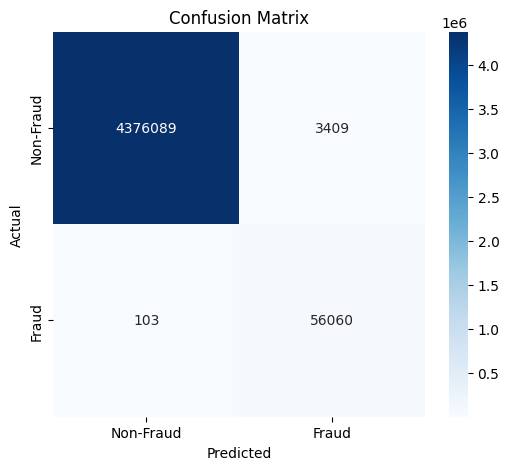

In [9]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

X_test = df_test.drop(columns=[target])
y_test = df_test[target]

# Dự đoán trên tập test
y_pred = full_pipeline.predict(X_test)

# Đánh giá mô hình với classification report và confusion matrix
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Vẽ confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [10]:
# Định nghĩa độ đo tùy chỉnh (Partial AUC)
def custom_metric(y_true, y_pred_proba):
    min_tpr = 0.80  # Ngưỡng TPR tối thiểu
    max_fpr = abs(1 - min_tpr)  # Ngưỡng FPR tối đa
    
    v_gt = abs(y_true - 1)  # Chuyển đổi y_true thành lớp tích cực (1) và lớp tiêu cực (0)
    v_pred = np.array([1.0 - x for x in y_pred_proba])  # Chuyển đổi xác suất dự đoán thành lớp tiêu cực
    
    partial_auc_scaled = roc_auc_score(v_gt, v_pred, max_fpr=max_fpr)  # Tính AUC của phần có FPR giới hạn
    partial_auc = 0.5 * max_fpr**2 + (max_fpr - 0.5 * max_fpr**2) / (1.0 - 0.5) * (partial_auc_scaled - 0.5)  # Điều chỉnh AUC

    return partial_auc

# Lấy xác suất dự đoán của lớp tích cực (Fraud)
y_pred_proba = full_pipeline.predict_proba(X_test)[:, 1]  # Dự đoán xác suất lớp tích cực (Fraud)

# Tính độ đo tùy chỉnh trên tập test
custom_auc_score = custom_metric(y_test, y_pred_proba)

# In kết quả độ đo tùy chỉnh
print(f'Custom pAUC Score: {custom_auc_score}')
print(f'AUC Score: {roc_auc_score(y_test, y_pred_proba)}')

Custom pAUC Score: 0.19997327646144938
AUC Score: 0.9999638359379777


Text(0, 0.5, 'True Positive Rate')

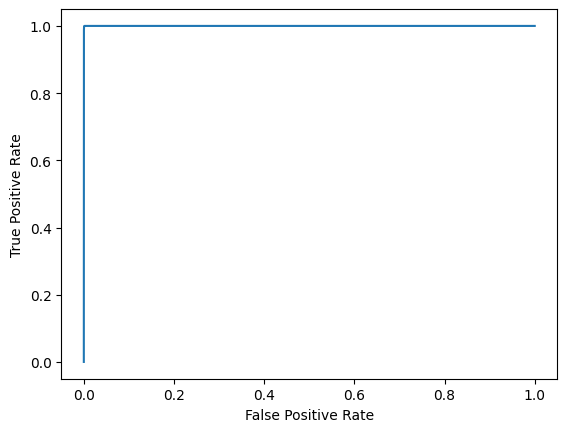

In [11]:
# Ve ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

C:\Users\HOME\AppData\Local\Temp\ipykernel_13964\3932963346.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  s.set_xticklabels(s.get_xticklabels(),rotation=90)


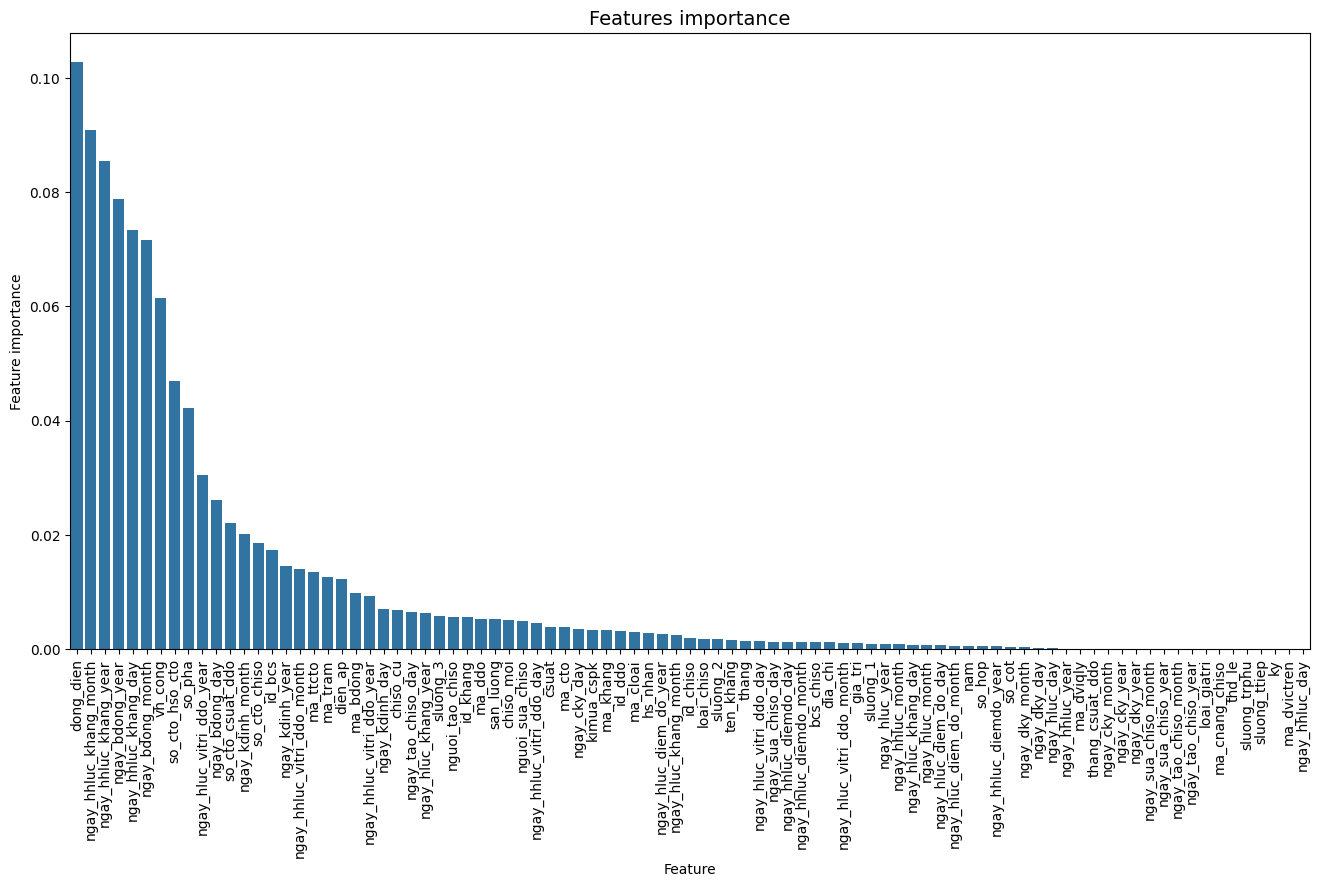

In [12]:
Features = [col for col in df_train.columns if col != target]
tmp = pd.DataFrame({'Feature': Features, 'Feature importance': model.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (16,8))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()